In [1]:
!pip install torch torchvision datasets
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m2le4arv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-m2le4arv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=802111945f00e9e79fe3c312b7d7bcc5028b8ca332c70dea766c8b08d8e01e04
  Stored in directory: /tmp/pip-ephem-wheel-cache-7p7s3hn2/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from datasets import load_dataset
import clip
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
model, preprocess = clip.load("ViT-B/16", device = device, jit=False)

100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 78.0MiB/s]


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ds = load_dataset("aggr8/brain_mri_train_test_split")

text_prompts = ["a photo of glioma tumor", "a photo of meningioma tumor", "a photo of no tumor", "a photo of pituitary tumor"]

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


class CustomImageDatasetTrain(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = clip.tokenize([text_prompts[label] for label in labels])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transformations = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

dataset = CustomImageDatasetTrain(ds["train"]["image"], ds["train"]["label"], transform=transformations)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_dataset_2 = CustomImageDataset(ds["train"]["image"], ds["train"]["label"])
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=32, shuffle=False)

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

In [10]:
import torch
import torch.nn as nn
import math
from functools import reduce
from operator import mul
from torch.nn import Dropout
from transformers import CLIPModel

# Adding learnnable prompt embeddings to the Vision Permuter Transformer
class PromptedTransformer(nn.Module):
    def __init__(self, prompt_config, config, img_size, vis):
        super(PromptedTransformer, self).__init__()

        self.prompt_config = prompt_config
        self.vit_config = config
        self.vis = vis
        img_size = (img_size, img_size)

        num_tokens = self.prompt_config["NUM_TOKENS"]
        self.num_tokens = num_tokens  
        self.prompt_dropout = Dropout(self.prompt_config["DROPOUT"])

        prompt_dim = config.hidden_size if self.prompt_config["PROJECT"] == -1 else self.prompt_config["PROJECT"]
        self.prompt_proj = nn.Linear(prompt_dim, config.hidden_size) if self.prompt_config["PROJECT"] > -1 else nn.Identity()

        if self.prompt_config["INITIATION"] == "random":
            val = math.sqrt(6. / float(3 * img_size[0] * img_size[1] + prompt_dim))
            self.prompt_embeddings = nn.Parameter(torch.zeros(1, num_tokens, prompt_dim))
            nn.init.uniform_(self.prompt_embeddings.data, -val, val)

            if self.prompt_config.get("DEEP", False):
                total_d_layer = config.num_hidden_layers - 1 
                self.deep_prompt_embeddings = nn.Parameter(torch.zeros(total_d_layer, num_tokens, prompt_dim))
                nn.init.uniform_(self.deep_prompt_embeddings.data, -val, val)
        else:
            raise ValueError("Only random initiation is supported")

    def incorporate_prompt(self, x):
        B = x.shape[0]
        x = torch.cat((
            x[:, :1, :],  
            self.prompt_dropout(self.prompt_proj(self.prompt_embeddings).expand(B, -1, -1)),
            x[:, 1:, :]  
        ), dim=1)
        return x

    def forward(self, x):
        embedding_output = self.incorporate_prompt(x)
        encoded = self.prompt_proj(embedding_output)  
        return encoded


class CLIP_VPT_Classifier(nn.Module):
    def __init__(self, clip_model_name: str, num_classes: int, prompt_cfg):
        super(CLIP_VPT_Classifier, self).__init__()
        
        self.clip_model = CLIPModel.from_pretrained(clip_model_name)

        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.prompted_vit = PromptedTransformer(prompt_cfg, self.clip_model.vision_model.config, img_size=224, vis=False)

        self.head = nn.Linear(self.clip_model.vision_model.config.hidden_size, num_classes)
        nn.init.kaiming_normal_(self.head.weight, a=0, mode='fan_out')

    def forward(self, pixel_values):
        x = self.clip_model.vision_model(pixel_values).last_hidden_state
        encoded = self.prompted_vit(x)

        cls_token_output = encoded[:, 0]  
        logits = self.head(cls_token_output)

        return logits



num_classes = 4 
prompt_cfg = {
    "NUM_TOKENS": 5,
    "DROPOUT": 0.1,
    "PROJECT": -1,
    "INITIATION": "random"
}

model_ft = CLIP_VPT_Classifier(clip_model_name="openai/clip-vit-base-patch16", num_classes=num_classes, prompt_cfg=prompt_cfg).to(device)



In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-2)

Epoch 1/50, Loss: 1.1303: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Epoch [1/50], Loss: 1.1303, Training Accuracy: 58.54%
Validation Accuracy: 55.94%
Best model saved with accuracy 55.94%


Epoch 2/50, Loss: 0.8429: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Epoch [2/50], Loss: 0.8429, Training Accuracy: 66.46%
Validation Accuracy: 65.94%
Convergence Speed - Training Accuracy: 7.9167, Validation Accuracy: 10.0000
Convergence Speed - Training Loss: 0.2874, Validation Loss: 0.2088
Best model saved with accuracy 65.94%


Epoch 3/50, Loss: 0.6765: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Epoch [3/50], Loss: 0.6765, Training Accuracy: 73.33%
Validation Accuracy: 73.75%
Convergence Speed - Training Accuracy: 6.8750, Validation Accuracy: 7.8125
Convergence Speed - Training Loss: 0.1665, Validation Loss: 0.1171
Best model saved with accuracy 73.75%


Epoch 4/50, Loss: 0.5711: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Epoch [4/50], Loss: 0.5711, Training Accuracy: 78.54%
Validation Accuracy: 76.25%
Convergence Speed - Training Accuracy: 5.2083, Validation Accuracy: 2.5000
Convergence Speed - Training Loss: 0.1054, Validation Loss: 0.0739
Best model saved with accuracy 76.25%


Epoch 5/50, Loss: 0.4981: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Epoch [5/50], Loss: 0.4981, Training Accuracy: 80.62%
Validation Accuracy: 78.75%
Convergence Speed - Training Accuracy: 2.0833, Validation Accuracy: 2.5000
Convergence Speed - Training Loss: 0.0729, Validation Loss: 0.0552
Best model saved with accuracy 78.75%


Epoch 6/50, Loss: 0.4442: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Epoch [6/50], Loss: 0.4442, Training Accuracy: 81.67%
Validation Accuracy: 79.38%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0540, Validation Loss: 0.0437
Best model saved with accuracy 79.38%


Epoch 7/50, Loss: 0.4018: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch [7/50], Loss: 0.4018, Training Accuracy: 83.12%
Validation Accuracy: 80.62%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: 0.0424, Validation Loss: 0.0345
Best model saved with accuracy 80.62%


Epoch 8/50, Loss: 0.3673: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch [8/50], Loss: 0.3673, Training Accuracy: 84.58%
Validation Accuracy: 80.94%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0345, Validation Loss: 0.0274
Best model saved with accuracy 80.94%


Epoch 9/50, Loss: 0.3387: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch [9/50], Loss: 0.3387, Training Accuracy: 85.62%
Validation Accuracy: 80.94%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0285, Validation Loss: 0.0221


Epoch 10/50, Loss: 0.3148: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch [10/50], Loss: 0.3148, Training Accuracy: 86.88%
Validation Accuracy: 82.50%
Convergence Speed - Training Accuracy: 1.2500, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0239, Validation Loss: 0.0180
Best model saved with accuracy 82.50%


Epoch 11/50, Loss: 0.2943: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [11/50], Loss: 0.2943, Training Accuracy: 87.71%
Validation Accuracy: 82.50%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0204, Validation Loss: 0.0147


Epoch 12/50, Loss: 0.2766: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Epoch [12/50], Loss: 0.2766, Training Accuracy: 88.54%
Validation Accuracy: 83.44%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0177, Validation Loss: 0.0118
Best model saved with accuracy 83.44%


Epoch 13/50, Loss: 0.2609: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Epoch [13/50], Loss: 0.2609, Training Accuracy: 88.96%
Validation Accuracy: 83.75%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0157, Validation Loss: 0.0092
Best model saved with accuracy 83.75%


Epoch 14/50, Loss: 0.2469: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [14/50], Loss: 0.2469, Training Accuracy: 89.58%
Validation Accuracy: 84.06%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0141, Validation Loss: 0.0068
Best model saved with accuracy 84.06%


Epoch 15/50, Loss: 0.2341: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch [15/50], Loss: 0.2341, Training Accuracy: 91.04%
Validation Accuracy: 84.06%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0128, Validation Loss: 0.0047


Epoch 16/50, Loss: 0.2223: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch [16/50], Loss: 0.2223, Training Accuracy: 92.29%
Validation Accuracy: 84.06%
Convergence Speed - Training Accuracy: 1.2500, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0117, Validation Loss: 0.0029


Epoch 17/50, Loss: 0.2115: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch [17/50], Loss: 0.2115, Training Accuracy: 92.50%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0109, Validation Loss: 0.0016
Best model saved with accuracy 84.38%


Epoch 18/50, Loss: 0.2013: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch [18/50], Loss: 0.2013, Training Accuracy: 92.71%
Validation Accuracy: 85.00%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0101, Validation Loss: 0.0007
Best model saved with accuracy 85.00%


Epoch 19/50, Loss: 0.1918: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [19/50], Loss: 0.1918, Training Accuracy: 92.71%
Validation Accuracy: 84.69%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0095, Validation Loss: 0.0004


Epoch 20/50, Loss: 0.1829: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch [20/50], Loss: 0.1829, Training Accuracy: 93.12%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0089, Validation Loss: 0.0006


Epoch 21/50, Loss: 0.1745: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [21/50], Loss: 0.1745, Training Accuracy: 93.12%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0084, Validation Loss: 0.0011


Epoch 22/50, Loss: 0.1666: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Epoch [22/50], Loss: 0.1666, Training Accuracy: 94.17%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0079, Validation Loss: 0.0018


Epoch 23/50, Loss: 0.1593: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch [23/50], Loss: 0.1593, Training Accuracy: 95.62%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0074, Validation Loss: 0.0025


Epoch 24/50, Loss: 0.1523: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch [24/50], Loss: 0.1523, Training Accuracy: 96.04%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0069, Validation Loss: 0.0031


Epoch 25/50, Loss: 0.1458: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch [25/50], Loss: 0.1458, Training Accuracy: 96.04%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0065, Validation Loss: 0.0036


Epoch 26/50, Loss: 0.1396: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [26/50], Loss: 0.1396, Training Accuracy: 96.67%
Validation Accuracy: 85.31%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0062, Validation Loss: 0.0039
Best model saved with accuracy 85.31%


Epoch 27/50, Loss: 0.1337: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch [27/50], Loss: 0.1337, Training Accuracy: 97.08%
Validation Accuracy: 85.31%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0059, Validation Loss: 0.0039


Epoch 28/50, Loss: 0.1281: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Epoch [28/50], Loss: 0.1281, Training Accuracy: 97.29%
Validation Accuracy: 85.62%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0056, Validation Loss: 0.0037
Best model saved with accuracy 85.62%


Epoch 29/50, Loss: 0.1228: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [29/50], Loss: 0.1228, Training Accuracy: 97.50%
Validation Accuracy: 85.62%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0053, Validation Loss: 0.0033


Epoch 30/50, Loss: 0.1177: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [30/50], Loss: 0.1177, Training Accuracy: 97.50%
Validation Accuracy: 86.25%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0050, Validation Loss: 0.0029
Best model saved with accuracy 86.25%


Epoch 31/50, Loss: 0.1130: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch [31/50], Loss: 0.1130, Training Accuracy: 98.12%
Validation Accuracy: 86.25%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0047, Validation Loss: 0.0024


Epoch 32/50, Loss: 0.1087: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch [32/50], Loss: 0.1087, Training Accuracy: 98.33%
Validation Accuracy: 86.25%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0043, Validation Loss: 0.0018


Epoch 33/50, Loss: 0.1047: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch [33/50], Loss: 0.1047, Training Accuracy: 98.75%
Validation Accuracy: 85.94%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0040, Validation Loss: 0.0013


Epoch 34/50, Loss: 0.1011: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch [34/50], Loss: 0.1011, Training Accuracy: 99.17%
Validation Accuracy: 86.25%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0036, Validation Loss: 0.0009


Epoch 35/50, Loss: 0.0978: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Epoch [35/50], Loss: 0.0978, Training Accuracy: 99.17%
Validation Accuracy: 86.25%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0033, Validation Loss: 0.0006


Epoch 36/50, Loss: 0.0948: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [36/50], Loss: 0.0948, Training Accuracy: 99.17%
Validation Accuracy: 86.25%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0030, Validation Loss: 0.0003


Epoch 37/50, Loss: 0.0921: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Epoch [37/50], Loss: 0.0921, Training Accuracy: 99.17%
Validation Accuracy: 86.56%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0027, Validation Loss: 0.0002
Best model saved with accuracy 86.56%


Epoch 38/50, Loss: 0.0896: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [38/50], Loss: 0.0896, Training Accuracy: 99.17%
Validation Accuracy: 86.56%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0025, Validation Loss: 0.0002


Epoch 39/50, Loss: 0.0872: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [39/50], Loss: 0.0872, Training Accuracy: 99.17%
Validation Accuracy: 86.88%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0023, Validation Loss: 0.0002
Best model saved with accuracy 86.88%


Epoch 40/50, Loss: 0.0851: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [40/50], Loss: 0.0851, Training Accuracy: 99.17%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0022, Validation Loss: 0.0004
Best model saved with accuracy 87.50%


Epoch 41/50, Loss: 0.0830: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch [41/50], Loss: 0.0830, Training Accuracy: 99.17%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0021, Validation Loss: 0.0007


Epoch 42/50, Loss: 0.0810: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch [42/50], Loss: 0.0810, Training Accuracy: 99.38%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0020, Validation Loss: 0.0010


Epoch 43/50, Loss: 0.0791: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [43/50], Loss: 0.0791, Training Accuracy: 99.38%
Validation Accuracy: 87.19%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0015


Epoch 44/50, Loss: 0.0773: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Epoch [44/50], Loss: 0.0773, Training Accuracy: 99.58%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0020


Epoch 45/50, Loss: 0.0754: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch [45/50], Loss: 0.0754, Training Accuracy: 99.38%
Validation Accuracy: 86.88%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: 0.0018, Validation Loss: 0.0026


Epoch 46/50, Loss: 0.0736: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [46/50], Loss: 0.0736, Training Accuracy: 99.38%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0018, Validation Loss: 0.0033


Epoch 47/50, Loss: 0.0717: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [47/50], Loss: 0.0717, Training Accuracy: 99.38%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0039


Epoch 48/50, Loss: 0.0698: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Epoch [48/50], Loss: 0.0698, Training Accuracy: 99.38%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0045
Best model saved with accuracy 87.81%


Epoch 49/50, Loss: 0.0679: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Epoch [49/50], Loss: 0.0679, Training Accuracy: 99.58%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0048


Epoch 50/50, Loss: 0.0659: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [50/50], Loss: 0.0659, Training Accuracy: 99.58%
Validation Accuracy: 87.50%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0019, Validation Loss: 0.0048


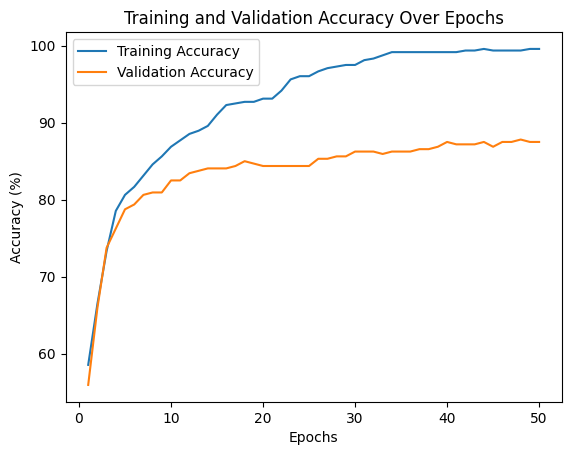

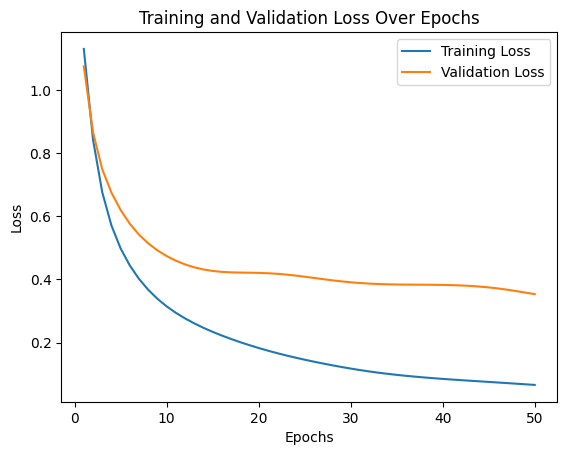

In [14]:
from tqdm import tqdm
import torch
import os

num_epochs = 50

best_accuracy = 0

best_model_path = "/kaggle/working/shallow_finetune_best_model_1.pth"

train_acc = []
test_acc = []
epoches = []
train_loss = []
test_loss = []
prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad() 
        outputs = model_ft(images) 
        
        _, predicted = torch.max(outputs.data, 1) 
        pred_label.extend(predicted.cpu().numpy())  
        true_label.extend(labels.cpu().numpy()) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        running_loss += loss.item()  
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}") 

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 1)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval() 
    correct = 0 
    total = 0 
    running_loss_test = 0
    with torch.no_grad(): 
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model_ft(images) 
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()  
            loss = criterion(outputs, labels)  
            running_loss_test += loss.item() 

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%') 

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/kaggle/working/", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [15]:
from tqdm import tqdm
import torch
import os

num_epochs = 50

best_model_path = "/kaggle/working/shallow_finetune_best_model_1.pth"


prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad() 
        outputs = model_ft(images) 
        
        _, predicted = torch.max(outputs.data, 1) 
        pred_label.extend(predicted.cpu().numpy())  
        true_label.extend(labels.cpu().numpy()) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        running_loss += loss.item()  
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}") 

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 51)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval() 
    correct = 0 
    total = 0 
    running_loss_test = 0
    with torch.no_grad(): 
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model_ft(images) 
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()  
            loss = criterion(outputs, labels)  
            running_loss_test += loss.item() 

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%') 

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/kaggle/working/", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1/50, Loss: 0.0640: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch [1/50], Loss: 0.0640, Training Accuracy: 99.58%
Validation Accuracy: 87.81%


Epoch 2/50, Loss: 0.0623: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch [2/50], Loss: 0.0623, Training Accuracy: 99.58%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0018, Validation Loss: 0.0034


Epoch 3/50, Loss: 0.0607: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch [3/50], Loss: 0.0607, Training Accuracy: 99.58%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0016, Validation Loss: 0.0021


Epoch 4/50, Loss: 0.0593: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch [4/50], Loss: 0.0593, Training Accuracy: 99.58%
Validation Accuracy: 88.12%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: 0.0014, Validation Loss: 0.0005
Best model saved with accuracy 88.12%


Epoch 5/50, Loss: 0.0582: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch [5/50], Loss: 0.0582, Training Accuracy: 99.58%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0011, Validation Loss: -0.0010


Epoch 6/50, Loss: 0.0573: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Epoch [6/50], Loss: 0.0573, Training Accuracy: 99.58%
Validation Accuracy: 87.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0010, Validation Loss: -0.0024


Epoch 7/50, Loss: 0.0294:  60%|██████    | 9/15 [00:03<00:02,  2.25it/s]


KeyboardInterrupt: 

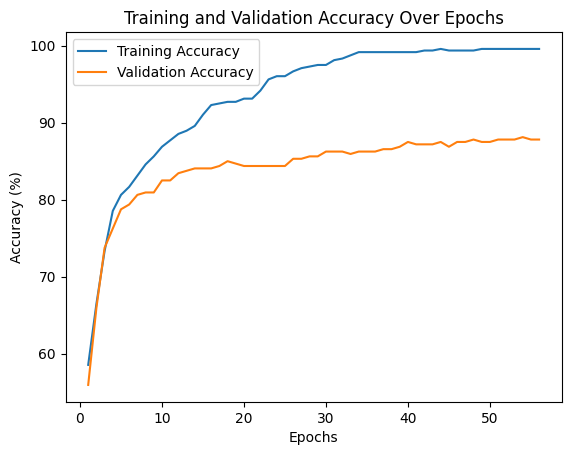

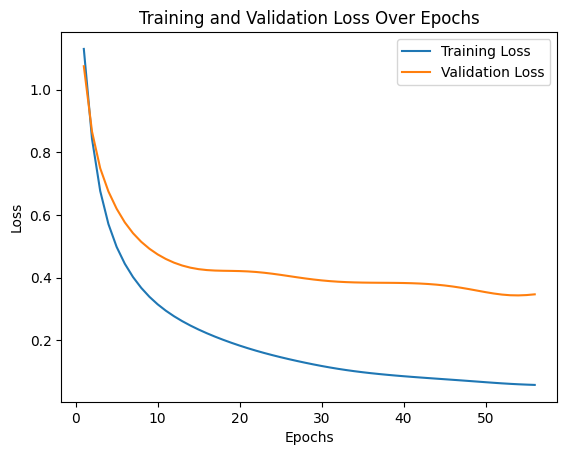

In [16]:
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()
